# **Lab 1**

## **Data Extraction**

In [173]:
# Setup
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings 
warnings.simplefilter(action = 'ignore')

import matplotlib
matplotlib.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": "Times New Roman"})

In [174]:
# Transform .dat file to .csv
for file in ["NACA0012_25Hz_70pitch", "NACA4412_25Hz_70pitch"]:
    datContent = []
    for i in open(file + ".dat").readlines():
        if str(i[0]) in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "-"]:
            datContent.append(i.strip().split())

    with open(file + ".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(datContent)

In [175]:
# Transform .csv to DataFrames

naca0012_data = {}
naca4412_data = {}

for file in ["NACA0012_25Hz_70pitch", "NACA4412_25Hz_70pitch"]:

    if file == "NACA0012_25Hz_70pitch":
        storage = naca0012_data
    elif file == "NACA4412_25Hz_70pitch":
        storage = naca4412_data

    df_composite = pd.read_csv(file + ".csv", index_col = 0, header = None, names = ["Dyn. Pressure (In. H20)", "Surf. Pressure (In. H20)"])

    # Break each airfoil's data into data for each AoA
    chunk_size = 19
    num_chunks = int(len(df_composite.index) / 19)

    for i in range(num_chunks):
        chunk_old = df_composite.iloc[chunk_size * i:chunk_size * (i+1)]
        chunk = chunk_old.iloc[1:, :]
        chunk.name = int(chunk_old.index[0])

        storage[chunk.name] = chunk

In [176]:
# Correcting pressure tap 17 for NACA4412

port_17 = pd.DataFrame(data = {'AoA': [0, 4, 6, 8, 10, 12, 14], 'Dynamic': [2.557, 2.614, 2.626, 2.644, 2.655, 2.654, 2.653], 'Static': [-0.193, 0.948, 1.117, 1.337, 1.451, 1.526, 1.580]})
i = 0
for item in naca4412_data:
    tbl = naca4412_data[item]
    tbl.loc[17][0] = port_17.iloc[i][1]
    tbl.loc[17][1] = port_17.iloc[i][2]
    naca4412_data[item] = tbl
    i += 1

In [177]:
# Plotting airfoil shape

#https://en.wikipedia.org/wiki/NACA_airfoil#Equation_for_a_cambered_4-digit_NACA_airfoil
def camber_line( x, m, p, c ):
    return np.where((x>=0)&(x<=(c*p)),
                    m * (x / np.power(p,2)) * (2.0 * p - (x / c)),
                    m * ((c - x) / np.power(1-p,2)) * (1.0 + (x / c) - 2.0 * p ))

def dyc_over_dx( x, m, p, c ):
    return np.where((x>=0)&(x<=(c*p)),
                    ((2.0 * m) / np.power(p,2)) * (p - x / c),
                    ((2.0 * m ) / np.power(1-p,2)) * (p - x / c ))

def thickness( x, t, c ):
    term1 =  0.2969 * (np.sqrt(x/c))
    term2 = -0.1260 * (x/c)
    term3 = -0.3516 * np.power(x/c,2)
    term4 =  0.2843 * np.power(x/c,3)
    term5 = -0.1015 * np.power(x/c,4)
    return 5 * t * c * (term1 + term2 + term3 + term4 + term5)

def _naca4(x, m, p, t, c=1):
    dyc_dx = dyc_over_dx(x, m, p, c)
    th = np.arctan(dyc_dx)
    yt = thickness(x, t, c)
    yc = camber_line(x, m, p, c)  
    return ((x - yt*np.sin(th), yc + yt*np.cos(th)), 
            (x + yt*np.sin(th), yc - yt*np.cos(th)))

def naca4(x, m, p, t, c=1):
    xu = []
    xl = []
    yu = []
    yl = []
    
    for xi in x:
        yt = thickness(xi, t, c)
        if xi < p * c:
            yc = camber_line(xi, m, p, c)
            th = np.arctan(dyc_over_dx(xi, m, p, c))
            xu.append(xi - yt * np.sin(th))
            xl.append(xi + yt * np.sin(th))
            yu.append(yc + yt * np.cos(th))
            yl.append(yc - yt * np.cos(th))
        else:
            yc = camber_line(xi, m, p, c)
            th = np.arctan(dyc_over_dx(xi, m, p, c))
            xu.append(xi - yt * np.sin(th))
            xl.append(xi + yt * np.sin(th))
            yu.append(yc + yt * np.cos(th))
            yl.append(yc - yt * np.cos(th))
    
    return np.array(xu), np.array(xl), np.array(yu), np.array(yl)

In [178]:
# Airfoil pressure tap geometry

naca0012_shape = pd.DataFrame(data = {
    'Tap': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
    'X Chord %': [0, 3.5, 8.8, 14.0, 19.3, 24.6, 29.8, 35.1, 40.4, 45.6, 50.9, 56.2, 61.4, 66.7, 72.0, 77.2, 82.5, 87.8],
    'Y Chord %': [0, 3.0, 4.5, 5.2, 5.7, 5.9, 6.0, 5.9, 5.8, 5.5, 5.2, 4.9, 4.4, 4.0, 3.5, 2.9, 2.3, 1.7]
})

naca4412_shape = pd.DataFrame(data = {
    'Tap': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
    'X Chord %': [0, 2.5, 5, 10, 20, 30, 40, 50, 70, 90, 85.8, 70, 50, 30, 20, 10, 6, 4], 
    'Y Chord %': [0, 3.4, 4.7, 6.6, 8.8, 9.8, 9.8, 9.2, 6.7, 2.7, -.3, -.7, -1.4, -2.3, -2.7, -2.9, -2.6, -2.3]
})

## **Task 1**

In [179]:
# Calculating U, Re, Cp

U_naca0012 = 33.3 # m/s
U_naca4412 = 34.0 # m/s

chord = .1524 # m [6 in]

p_atm = 98700 # Pa [29.15 in Hg]
T_atm = 300.93 # K [82 F, 27.78 C]
rho = 1.14486 # kg/m3 [at given p_atm and t_atm]
mu = 18.5 * 10**-6 # Pa*s

re_naca0012 = rho * U_naca0012 * chord / mu
re_naca4412 = rho * U_naca4412 * chord / mu

# Exporting all dataframes to single Excel sheet
writer = pd.ExcelWriter("Cp_Data.xlsx", engine = "xlsxwriter")
workbook=writer.book

Q = 0
for item in naca0012_data:
    tbl = naca0012_data[item]
    tbl["Cp"] = ((pd.to_numeric(tbl["Surf. Pressure (In. H20)"]))) / (pd.to_numeric(tbl["Dyn. Pressure (In. H20)"]))
    tbl["U"] = (2 * (pd.to_numeric(tbl["Dyn. Pressure (In. H20)"]) * 249.08) / rho) ** .5
    tbl["AoA"] = item
    naca0012_data[item] = tbl
    tbl.to_excel(writer, sheet_name='NACA0012', startrow=0 , startcol=(6*Q), index = False)
    Q += 1

Q = 0
for item in naca4412_data:
    tbl = naca4412_data[item]
    tbl["Cp"] = ((pd.to_numeric(tbl["Surf. Pressure (In. H20)"]))) / (pd.to_numeric(tbl["Dyn. Pressure (In. H20)"]))
    tbl["U"] = (2 * (pd.to_numeric(tbl["Dyn. Pressure (In. H20)"]) * 249.08) / rho) ** .5
    tbl["AoA"] = item
    naca4412_data[item] = tbl
    tbl.to_excel(writer, sheet_name='NACA4412', startrow=0 , startcol=(6*Q), index = False)
    Q += 1

writer.close()
workbook.close()

## **Task 2**

#### **2B**

In [180]:
# NACA 0012 Cp plotting function

def symmetrical_pressure_plot(i):

    if i == 0:
        j = 0
    else: j = -i

    fig, ax = plt.subplots(figsize = (10, 10))
    fig.patch.set_facecolor('white')

    ax2 = ax.twinx()
    x = np.linspace(0,100,200)
    for item in _naca4(x, 00, .00000001, .12, 100):
        ax2.plot(item[0], item[1], 'k')

    ax.set_ylim([max(naca0012_data[i]["Cp"].abs().max(axis = 0), naca0012_data[j]["Cp"].abs().max(axis = 0)) * -1.25, max(naca0012_data[i]["Cp"].abs().max(axis = 0), naca0012_data[j]["Cp"].abs().max(axis = 0)) * 1.25])
    ax.set_ylim(ax.get_ylim()[::-1])
    ax2.set_ylim([-50, 50])
    # ax2.plot(naca0012_shape["X Chord %"], naca0012_shape["Y Chord %"], 'mo', markersize = 5)
    ax2.get_yaxis().set_visible(False)
    ax.plot(naca0012_shape["X Chord %"], naca0012_data[i]["Cp"], 'b')
    ax.plot(naca0012_shape["X Chord %"], naca0012_data[j]["Cp"], 'b')
    ax.set_xlabel('Chord Percentage', fontsize = 16, fontweight = 'bold')
    ax.set_ylabel(r'$C_p$', fontsize = 16, fontweight = "bold")
    plt.title(rf"{i}$^\circ$ AoA - NACA 0012", fontsize = 20, fontweight = 'bold')
    plt.xlim((-1, 101))
    ax.spines[['right', 'top']].set_visible(False)
    ax2.spines[['right', 'top']].set_visible(False)
    return plt

In [181]:
# NACA 4412 Cp plotting function

def cambered_pressure_plot(i):
    fig, ax = plt.subplots(figsize = (10, 10))
    fig.patch.set_facecolor('white')

    ax2 = ax.twinx()
    x = np.linspace(0,100,200)
    for item in _naca4(x, .04, .4, .12, 100):
        ax2.plot(item[0], item[1], 'k')

    ax.set_ylim([naca4412_data[i]["Cp"].abs().max(axis = 0) * -1.25, naca4412_data[i]["Cp"].abs().max(axis = 0) * 1.25])
    ax.set_ylim(ax.get_ylim()[::-1])
    ax2.set_ylim([-50, 50])
    # ax2.plot(naca4412_shape["X Chord %"], naca4412_shape["Y Chord %"], 'mo', markersize = 5)
    ax2.get_yaxis().set_visible(False)
    ax.plot(naca4412_shape["X Chord %"], naca4412_data[i]["Cp"], 'b')
    ax.set_xlabel('Chord Percentage', fontsize = 16, fontweight = 'bold')
    ax.set_ylabel(r'$C_p$', fontsize = 16, fontweight = "bold")
    plt.title(rf"{i}$^\circ$ AoA - NACA 4412", fontsize = 20, fontweight = 'bold')
    plt.xlim((-1, 101))
    ax.spines[['right', 'top']].set_visible(False)
    ax2.spines[['right', 'top']].set_visible(False)
    return plt

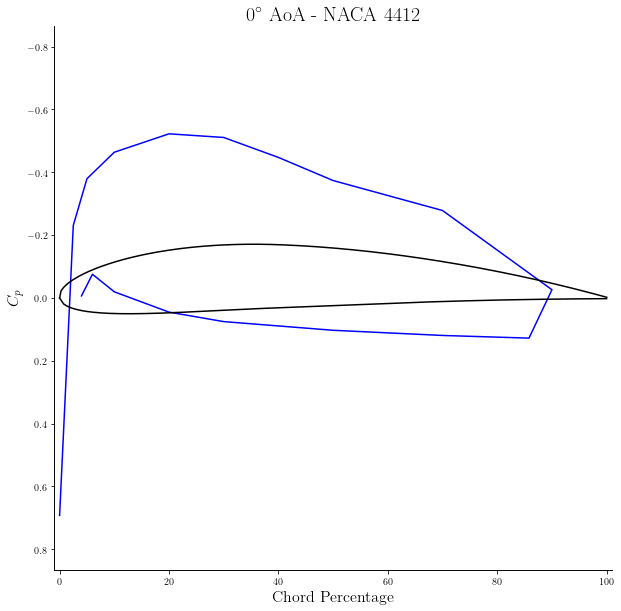

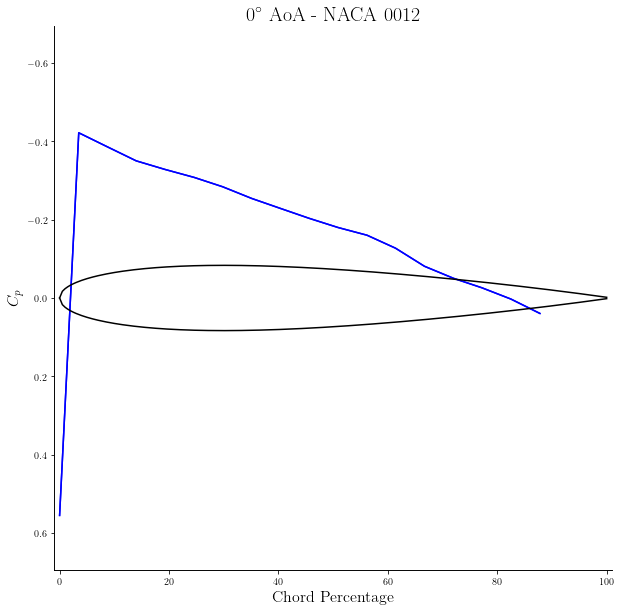

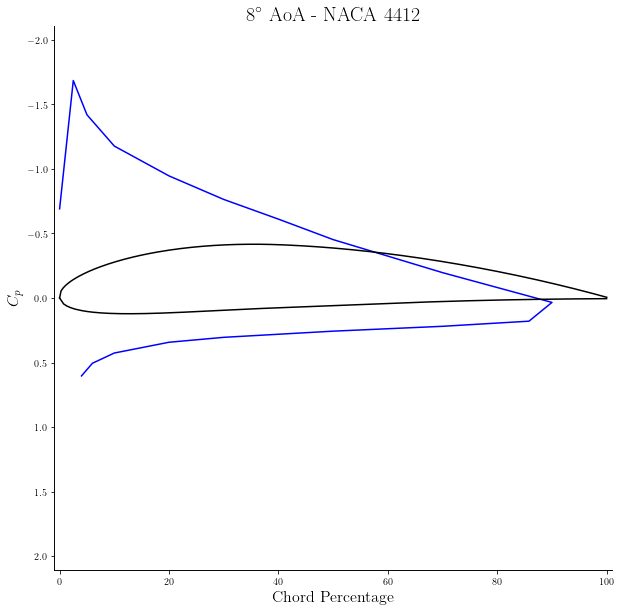

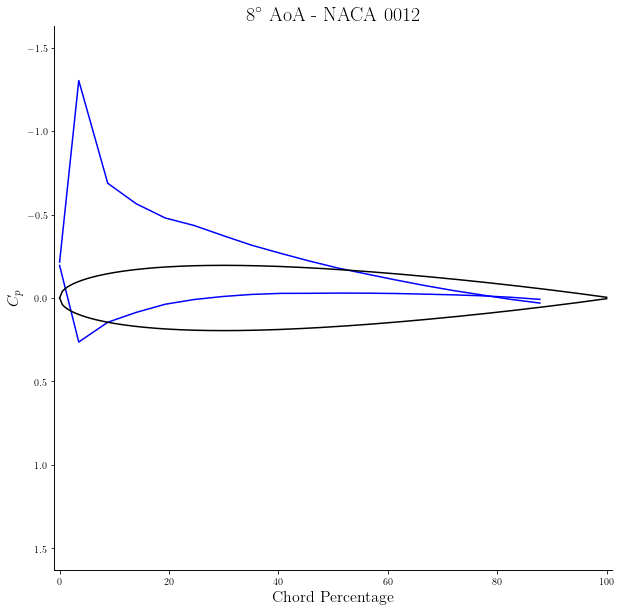

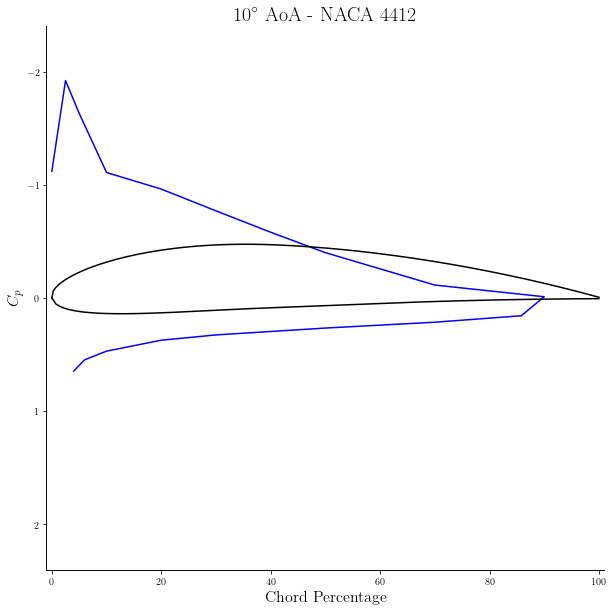

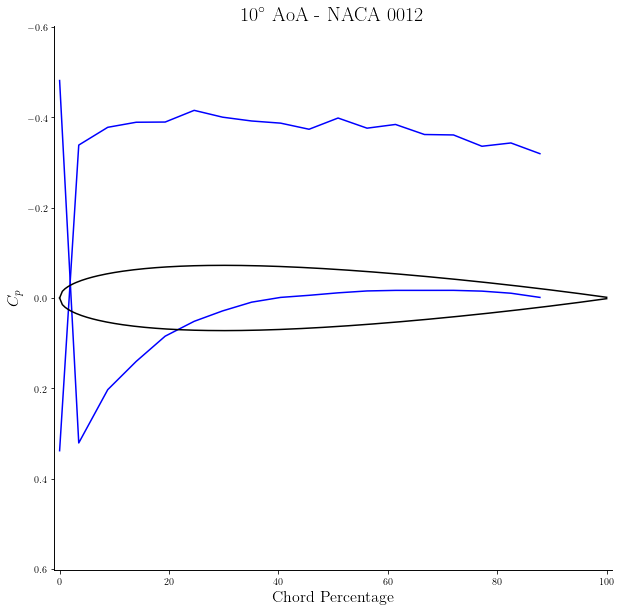

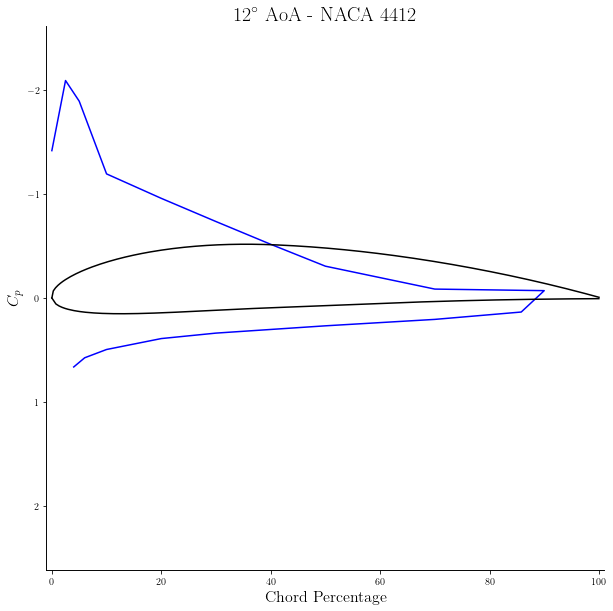

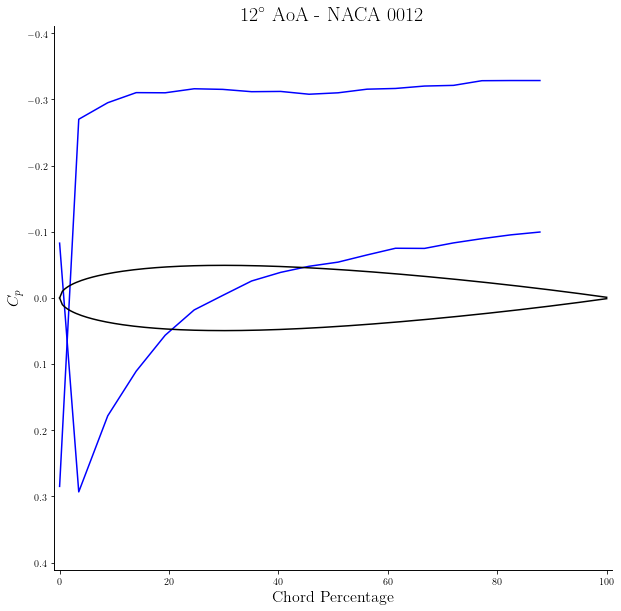

In [182]:
# Iterate through each AoA and save the figures to respective folders

for i in [0, 8, 10, 12]:
    cambered_pressure_plot(i).savefig(f'naca4412_Cp/4412_{i}_AoA_Cp.png')
    symmetrical_pressure_plot(i).savefig(f'naca0012_Cp/0012_{i}_AoA_Cp.png')


#### **2A**

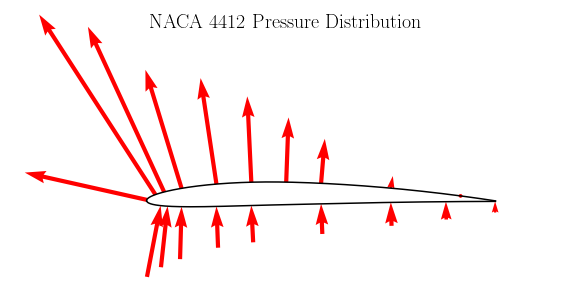

In [183]:
# NACA4412 pressure distribution
m = 0.04  # Maximum camber
p = 0.4   # Location of maximum camber
t = 0.12  # Thickness
c = 1.0   # Chord length

# Generate x-coordinates
x = np.linspace(0, 1, 5000)

# Calculate airfoil coordinates
x_upper, x_lower, y_upper, y_lower = naca4(x, m, p, t, c)

# Specify the x-coordinates for the vectors on the upper and lower surfaces separately 
vector_x_coordinates_upper = [0.0001, .025, .05, .1, .2, .3, .4, .5, .7, .9]  # Specify x-coordinates for upper surface vectors
vector_x_coordinates_lower = [.858, .7, .5, .3, .2, .1, .06, .04, .999]  # Specify x-coordinates for lower surface vectors
vector_magnitudes_upper = [1.12, 1.92, 1.63, 1.11, 0.96, 0.77, 0.58, 0.40, 0.11, 0.01] # Specify the magnitudes of the vectors
vector_magnitudes_lower = [0.16,0.21,0.27,0.33,0.37,0.47,0.55,0.65,.1]  # Specify the magnitudes of the vectors

# Function to calculate the local normal vectors at specified x-coordinates for both surfaces
def calculate_specified_normals(x, y, vector_x_coordinates, vector_magnitudes):
    normals_x = []
    normals_y = []
    for xi, magnitude in zip(vector_x_coordinates, vector_magnitudes):
        idx = np.argmin(np.abs(x - xi))
        dx = x[idx + 1] - x[idx - 1]
        dy = y[idx + 1] - y[idx - 1]
        normal_length = np.sqrt(dx ** 2 + dy ** 2)
        
        normals_x.append(-dy / normal_length * magnitude)
        normals_y.append(dx / normal_length * magnitude)
    return normals_x, normals_y

# Calculate normal vectors for both surfaces at specified x-coordinates
normals_x_upper, normals_y_upper = calculate_specified_normals(x_upper, y_upper, vector_x_coordinates_upper, vector_magnitudes_upper)
normals_x_lower, normals_y_lower = calculate_specified_normals(x_lower, y_lower, vector_x_coordinates_lower, vector_magnitudes_lower)

# Plot the airfoil
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_upper, y_upper, 'k-')
ax.plot(x_lower, y_lower, 'k-')

# Plot specified normal vectors on the upper surface with arrow tips touching
ax.quiver(vector_x_coordinates_upper, [y_upper[np.argmin(np.abs(x_upper - xi))] for xi in vector_x_coordinates_upper],
           normals_x_upper, normals_y_upper, scale=5, color='r', label='Specified Normals (Top)', pivot='tail')

# Plot specified normal vectors on the lower surface with arrow tips touching
ax.quiver(vector_x_coordinates_lower, [y_lower[np.argmin(np.abs(x_lower - xi))] for xi in vector_x_coordinates_lower],
           normals_x_lower, normals_y_lower, scale=5, color='r', label='Specified Normals (Bottom)', pivot='tip')

ax.set_xlim(-.4, 1.2)
ax.set_ylim(-.4, 1)

title_text = 'NACA 4412 Pressure Distribution'
title_bbox = dict(boxstyle='square', facecolor='white', edgecolor='none', pad=0.3)
ax.text(0.5, 0.94, title_text, transform=ax.transAxes, fontsize=20, ha='center', va='center', bbox=title_bbox)

# Hide the top and right spines of the graph
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)

# Hide all tick marks
ax.set_xticks([])
ax.set_yticks([])

plt.show()


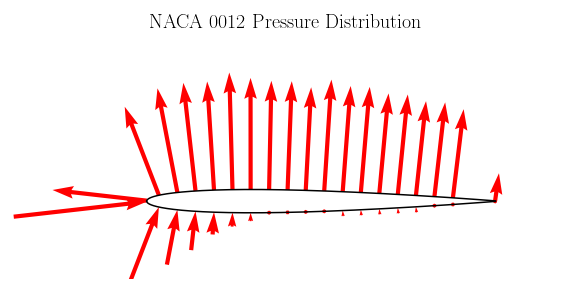

In [184]:
# NACA 0012 pressure distribution
m = 0.0    # Maximum camber
p = 0.00001    # Location of maximum camber
t = 0.12   # Thickness
c = 1.0    # Chord length

# Generate x-coordinates
x = np.linspace(0, 1, 5000)

# Calculate airfoil coordinates for NACA 0012
x_upper, x_lower, y_upper, y_lower = naca4(x, m, p, t, c)

# Specify the x-coordinates for the vectors on the upper and lower surfaces separately
vector_x_coordinates_upper = [0.0002, .035, .088, .14, .193, .246, .298, .351, .404, .456, .509, .562, .614, .667, .720, .772, .825, .878, .999]  # Specify x-coordinates for upper surface vectors
vector_x_coordinates_lower = vector_x_coordinates_upper  # Specify x-coordinates for lower surface vectors
vector_magnitudes_upper = [-0.34, 0.34, 0.38, 0.39, 0.39, 0.42, 0.40, 0.39, 0.39, 0.37, 0.40, 0.38, 0.38, 0.36, 0.36, 0.34, 0.34, 0.32, .1]  # Specify the magnitudes of the vectors
vector_magnitudes_lower = [-0.48, 0.32, 0.20, 0.14, 0.08, 0.05, 0.03, 0.01, 0.00, -0.01, -0.01, -0.02, -0.02, -0.02, -0.02, -0.02, -0.01, 0.00, .003]  # Specify the magnitudes of the vectors

# Function to calculate the local normal vectors at specified x-coordinates for both surfaces
def calculate_specified_normals(x, y, vector_x_coordinates, vector_magnitudes):
    normals_x = []
    normals_y = []
    pivot_values = []  # Store pivot values separately for each vector
    
    for xi, magnitude in zip(vector_x_coordinates, vector_magnitudes):
        idx = np.argmin(np.abs(x - xi))
        dx = x[idx + 1] - x[idx - 1]
        dy = y[idx + 1] - y[idx - 1]
        normal_length = np.sqrt(dx ** 2 + dy ** 2)
        
        normals_x.append(-dy / normal_length * abs(magnitude))
        normals_y.append(dx / normal_length * abs(magnitude))
        
        # Determine pivot based on magnitude
        if magnitude >= 0:
            pivot_values.append('tip')
        else:
            pivot_values.append('tail')
    
    # Set the first vector of each list to have the opposite "pivot" value
    pivot_values[0] = 'tail' if pivot_values[0] == 'tip' else 'tip'
    
    return normals_x, normals_y, pivot_values

# Calculate normal vectors for both surfaces at specified x-coordinates
normals_x_upper, normals_y_upper, pivot_upper = calculate_specified_normals(x_upper, y_upper, vector_x_coordinates_upper, vector_magnitudes_upper)
normals_x_lower, normals_y_lower, pivot_lower = calculate_specified_normals(x_lower, y_lower, vector_x_coordinates_lower, vector_magnitudes_lower)

# Plot the airfoil
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_upper, y_upper, 'k-')
ax.plot(x_lower, y_lower, 'k-')

# Plot specified normal vectors on the upper surface with arrow tips touching
ax.quiver(vector_x_coordinates_upper[0], y_upper[np.argmin(np.abs(x_upper - vector_x_coordinates_upper[0]))],
           normals_x_upper[0], normals_y_upper[0], scale=2, color='r', label='Specified Normals (Top)', pivot='tail')
ax.quiver(vector_x_coordinates_upper[1:], [y_upper[np.argmin(np.abs(x_upper - xi))] for xi in vector_x_coordinates_upper[1:]],
           normals_x_upper[1:], normals_y_upper[1:], scale=2, color='r')

# Plot specified normal vectors on the lower surface with arrow tips touching
ax.quiver(vector_x_coordinates_lower[0], y_lower[np.argmin(np.abs(x_lower - vector_x_coordinates_lower[0]))],
           normals_x_lower[0], normals_y_lower[0], scale=2, color='r', pivot=pivot_lower[0])
ax.quiver(vector_x_coordinates_lower[1:], [y_lower[np.argmin(np.abs(x_lower - xi))] for xi in vector_x_coordinates_lower[1:]],
           normals_x_lower[1:], normals_y_lower[1:], scale=2, color='r', pivot = "tip")

ax.set_xlim(-.4, 1.2)
ax.set_ylim(-.4, 1)

title_text = 'NACA 0012 Pressure Distribution'
title_bbox = dict(boxstyle='square', facecolor='white', edgecolor='none', pad=0.3)
ax.text(0.5, 0.94, title_text, transform=ax.transAxes, fontsize=20, ha='center', va='center', bbox=title_bbox)

# Hide the top and right spines of the graph
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)

# Hide all tick marks
ax.set_xticks([])
ax.set_yticks([])

plt.show()

## **Task 3**

$$
C_{n_u} = \sum_{i = L.E.}^{Taps} \frac{1}{2} \left[C_{P_{u(i+1)}}  + C_{P_{u(i)}} \right] \left[\left(\frac{x}{c} \right)_{u(i+1)} - \left(\frac{x}{c} \right)_{u(i)}\right]
$$

$$
C_{n_l} = \sum_{i = L.E.}^{Taps} \frac{1}{2} \left[C_{P_{l(i+1)}}  + C_{P_{l(i)}} \right] \left[\left(\frac{x}{c} \right)_{l(i+1)} - \left(\frac{x}{c} \right)_{l(i)}\right]
$$

$$
C_{c_u} = \sum_{i = L.E.}^{Taps} \frac{1}{2} \left[C_{P_{u(i+1)}}  + C_{P_{u(i)}} \right] \left[\left(\frac{y}{c} \right)_{u(i+1)} - \left(\frac{y}{c} \right)_{u(i)}\right]
$$

$$
C_{c_l} = \sum_{i = L.E.}^{Taps} \frac{1}{2} \left[C_{P_{l(i+1)}}  + C_{P_{l(i)}} \right] \left[\left(\frac{y}{c} \right)_{l(i+1)} - \left(\frac{y}{c} \right)_{l(i)}\right]
$$ 

---

$$C_n = C_{n_l} - C_{n_u}$$
$$C_c = C_{c_u} - C_{c_l}$$

---

$$C_l = C_n \cos(\alpha) - C_c \sin(\alpha)$$
$$C_d = C_c \cos(\alpha) + C_n \sin(\alpha)$$

In [185]:
# NACA 4412 - Cl and Cd

def cl_cd_4412(aoa):
    data = naca4412_data[aoa]
    ports = naca4412_shape

    # Calculate C_n_u
    C_n_u = 0
    for i in range(10):
        Cp_current = data.iloc[i, 2] # C_p_i
        xc_current = ports.iloc[i, 1] / 100 # (x/c)_i

        if i != 9: 
            Cp_next = data.iloc[i+1, 2] # C_p_(i+1)
            xc_next = ports.iloc[i+1, 1] /100 # (x/c)_i
        else: 
            Cp_next = 0 # Dealing with the last point in the sum
            xc_next = 1 # Dealing with the last point in the sum

        C_n_u = C_n_u + (1/2 * (Cp_next + Cp_current) * (xc_next - xc_current))

    # Calculate C_n_l
    C_n_l = 0
    for i in range(8):
        index = 10 + i

        Cp_current = data.iloc[index, 2] # C_p_i
        xc_current = ports.iloc[index, 1] / 100 # (x/c)_i

        if index != 17: 
            Cp_next = data.iloc[index+1, 2] # C_p_(i+1)
            xc_next = ports.iloc[index+1, 1] /100 # (x/c)_i
        else: 
            Cp_next = 0 # Dealing with the last point in the sum
            xc_next = 1 # Dealing with the last point in the sum

        C_n_l = C_n_l + (1/2 * (Cp_next + Cp_current) * (xc_next - xc_current))

    # Calculate C_c_u
    C_c_u = 0
    for i in range(10):
        Cp_current = data.iloc[i, 2] # C_p_i
        yc_current = ports.iloc[i, 2] / 100 # (y/c)_i

        if i != 9: 
            Cp_next = data.iloc[i+1, 2] # C_p_(i+1)
            yc_next = ports.iloc[i+1, 2] /100 # (y/c)_i
        else: 
            Cp_next = 0 # Dealing with the last point in the sum
            yc_next = 0 # Dealing with the last point in the sum

        C_c_u = C_c_u + (1/2 * (Cp_next + Cp_current) * (yc_next - yc_current))

    # Calculate C_c_l
    C_c_l = 0
    for i in range(8):
        index = 10 + i

        Cp_current = data.iloc[index, 2] # C_p_i
        yc_current = ports.iloc[index, 2] / 100 # (y/c)_i

        if index != 17: 
            Cp_next = data.iloc[index+1, 2] # C_p_(i+1)
            yc_next = ports.iloc[index+1, 2] /100 # (y/c)_i
        else: 
            Cp_next = 0 # Dealing with the last point in the sum
            yc_next = 0 # Dealing with the last point in the sum

        C_c_l = C_c_l + (1/2 * (Cp_next + Cp_current) * (yc_next - yc_current))

    C_n = C_n_l - C_n_u
    C_c = C_c_u - C_c_l

    Cl = (C_n * np.cos(aoa * np.pi / 180)) - (C_c * np.sin(aoa * np.pi / 180))
    Cd = (C_c * np.cos(aoa * np.pi / 180)) + (C_n * np.sin(aoa * np.pi / 180))

    return Cl, Cd

In [186]:
# NACA 0012 - Cl and Cd 

def cl_cd_0012(aoa):
    data_upper = naca0012_data[aoa]
    
    if aoa != 0:
        data_lower = naca0012_data[-1 * aoa]
    else:
        data_lower = data_upper
        
    ports = naca0012_shape

    # Calculate C_n_u, C_c_u
    C_n_u = 0
    C_c_u = 0
    for i in range(len(data_upper)):
        Cp_current = data_upper.iloc[i, 2] # C_p_i
        xc_current = ports.iloc[i, 1] / 100 # (x/c)_i
        yc_current = ports.iloc[i, 2] / 100 # (x/c)_i

        if i != 17: 
            Cp_next = data_upper.iloc[i+1, 2] # C_p_(i+1)
            xc_next = ports.iloc[i+1, 1] / 100 # (x/c)_(i+1)
            yc_next = ports.iloc[i+1, 2] / 100 #(y/c)_(i+1)
        else: 
            Cp_next = 0 # Dealing with the last point in the sum
            xc_next = 1 # Dealing with the last point in the sum
            yc_next = 0 # Dealing with the last point in the sum

        C_n_u = C_n_u + (1/2 * (Cp_next + Cp_current) * (xc_next - xc_current))
        C_c_u = C_c_u + (1/2 * (Cp_next + Cp_current) * (yc_next - yc_current))

    # Calculate C_n_l, C_c_l
    C_n_l = 0
    C_c_l = 0
    for i in range(len(data_upper)):
        Cp_current = data_lower.iloc[i, 2] # C_p_i
        xc_current = ports.iloc[i, 1] / 100 # (x/c)_i
        yc_current = ports.iloc[i, 2] / 100 # (x/c)_i

        if i != 17: 
            Cp_next = data_lower.iloc[i+1, 2] # C_p_(i+1)
            xc_next = ports.iloc[i+1, 1] / 100 # (x/c)_(i+1)
            yc_next = ports.iloc[i+1, 2] / 100 #(y/c)_(i+1)
        else: 
            Cp_next = 0 # Dealing with the last point in the sum
            xc_next = 1 # Dealing with the last point in the sum
            yc_next = 0 # Dealing with the last point in the sum

        C_n_l = C_n_u + (1/2 * (Cp_next + Cp_current) * (xc_next - xc_current))
        C_c_l = C_c_l + (1/2 * (Cp_next + Cp_current) * (yc_next - yc_current))

    C_n = C_n_l - C_n_u
    C_c = C_c_u - C_c_l

    Cl = (C_n * np.cos(aoa * np.pi / 180)) - (C_c * np.sin(aoa * np.pi / 180))
    Cd = (C_c * np.cos(aoa * np.pi / 180)) + (C_n * np.sin(aoa * np.pi / 180))

    return Cl, Cd

In [187]:
print("NACA 4412 \n")
for item in [0, 4, 6, 8, 10, 12, 14]:
    cl, cd = cl_cd_4412(item)
    print(item, "deg | ", "Cl: ", cl, "Cd:", cd)

print("----------------------------------------------------------------------\nNACA 0012 \n")
for item in [0, 4, 6, 8, 10, 12, 14]:
    cl, cd = cl_cd_0012(item)
    print(item, "deg | ", "Cl: ", cl, "Cd:", cd)

NACA 4412 

0 deg |  Cl:  0.24263173088057433 Cd: -0.000415007190999293
4 deg |  Cl:  0.47744420390447073 Cd: -0.026391055842910967
6 deg |  Cl:  0.5316640761268668 Cd: -0.02149908845777064
8 deg |  Cl:  0.5890766532571274 Cd: -0.024224018160702673
10 deg |  Cl:  0.5986761009297089 Cd: -0.02000871241071385
12 deg |  Cl:  0.6097246601164154 Cd: -0.012696745546069366
14 deg |  Cl:  0.633561982740816 Cd: 0.001752675927550601
----------------------------------------------------------------------
NACA 0012 

0 deg |  Cl:  0.002407894736842109 Cd: 0.0
4 deg |  Cl:  0.0014972510695742138 Cd: -0.026406625147701746
6 deg |  Cl:  0.004847735138621643 Cd: -0.035762407256129364
8 deg |  Cl:  0.007243952342608406 Cd: -0.04787865762556211
10 deg |  Cl:  -0.0006113549527065487 Cd: 0.003023997600184062
12 deg |  Cl:  -0.005047516522434299 Cd: -0.005493978586918959
14 deg |  Cl:  -0.008330127118133298 Cd: -0.01065224893433973


## **Task 4**

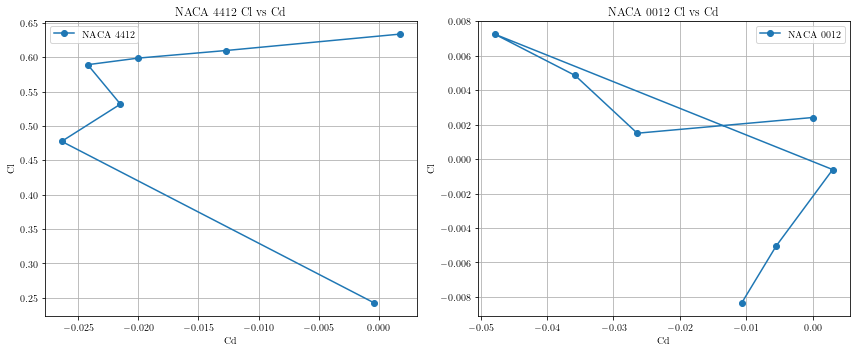

In [191]:
# Cl vs Cd
angles_of_attack = [0, 4, 6, 8, 10, 12, 14]


# Calculate Cl and Cd for both airfoils at different angles of attack
cl_4412 = []
cd_4412 = []
cl_0012 = []
cd_0012 = []

for aoa in angles_of_attack:
    cl, cd = cl_cd_4412(aoa)
    cl_4412.append(cl)
    cd_4412.append(cd)

    cl, cd = cl_cd_0012(aoa)
    cl_0012.append(cl)
    cd_0012.append(cd)

# Create two plots
plt.figure(figsize=(12, 5), facecolor = "white")

# Plot for NACA 4412
plt.subplot(1, 2, 1, facecolor = "white")
plt.plot(cd_4412, cl_4412, marker='o', linestyle='-', label='NACA 4412')
plt.xlabel('Cd')
plt.ylabel('Cl')
plt.title('NACA 4412 Cl vs Cd')
plt.grid(True)
plt.legend()

# Plot for NACA 0012
plt.subplot(1, 2, 2, facecolor = "white")
plt.plot(cd_0012, cl_0012, marker='o', linestyle='-', label='NACA 0012')
plt.xlabel('Cd')
plt.ylabel('Cl')
plt.title('NACA 0012 Cl vs Cd')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


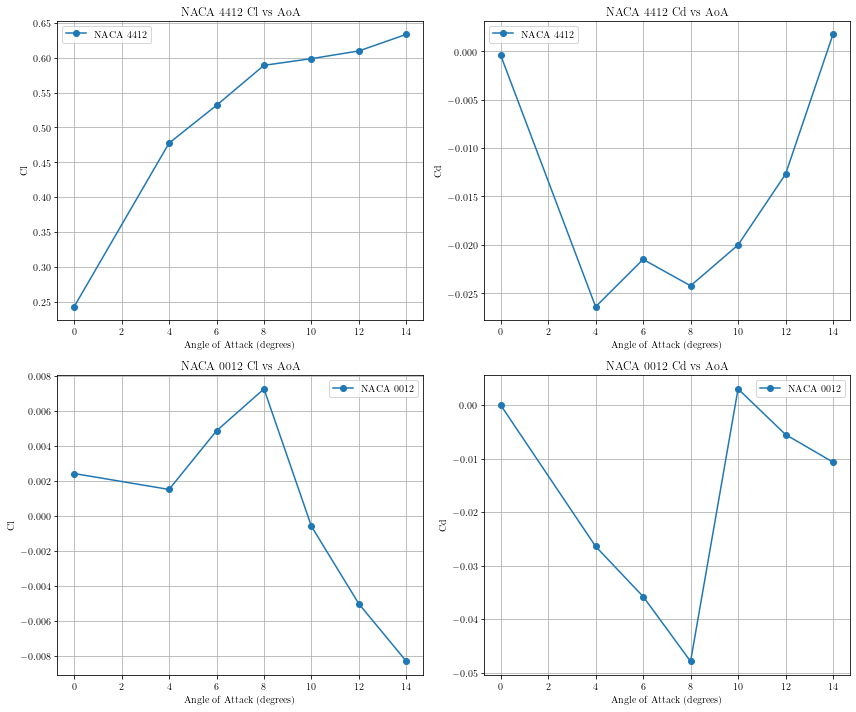

In [190]:
# Cl vs AoA, Cd vs AoA
angles_of_attack = [0, 4, 6, 8, 10, 12, 14]

# Calculate Cl and Cd for both airfoils at different angles of attack
cl_4412 = []
cd_4412 = []
cl_0012 = []
cd_0012 = []

for aoa in angles_of_attack:
    cl, cd = cl_cd_4412(aoa)
    cl_4412.append(cl)
    cd_4412.append(cd)

    cl, cd = cl_cd_0012(aoa)
    cl_0012.append(cl)
    cd_0012.append(cd)

# Create four plots (Cl vs AoA and Cd vs AoA for both airfoils)
plt.figure(figsize=(12, 10), facecolor='white')

# Plot Cl vs AoA for NACA 4412
plt.subplot(2, 2, 1, facecolor='white')
plt.plot(angles_of_attack, cl_4412, marker='o', linestyle='-', label='NACA 4412')
plt.xlabel('Angle of Attack (degrees)')
plt.ylabel('Cl')
plt.title('NACA 4412 Cl vs AoA')
plt.grid(True)
plt.legend()

# Plot Cd vs AoA for NACA 4412
plt.subplot(2, 2, 2, facecolor='white')
plt.plot(angles_of_attack, cd_4412, marker='o', linestyle='-', label='NACA 4412')
plt.xlabel('Angle of Attack (degrees)')
plt.ylabel('Cd')
plt.title('NACA 4412 Cd vs AoA')
plt.grid(True)
plt.legend()

# Plot Cl vs AoA for NACA 0012
plt.subplot(2, 2, 3, facecolor='white')
plt.plot(angles_of_attack, cl_0012, marker='o', linestyle='-', label='NACA 0012')
plt.xlabel('Angle of Attack (degrees)')
plt.ylabel('Cl')
plt.title('NACA 0012 Cl vs AoA')
plt.grid(True)
plt.legend()

# Plot Cd vs AoA for NACA 0012
plt.subplot(2, 2, 4, facecolor='white')
plt.plot(angles_of_attack, cd_0012, marker='o', linestyle='-', label='NACA 0012')
plt.xlabel('Angle of Attack (degrees)')
plt.ylabel('Cd')
plt.title('NACA 0012 Cd vs AoA')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
